In [2]:
# CELDA MÁGICA - EJECÚTALA PRIMERO EN TU NOTEBOOK ARMA.ipynb
import sys
import os

# Ruta al directorio que contiene todos los módulos (codigo_base)
CODE_BASE_PATH = r"C:\Users\pleal\Documents\Unal\Tesis\Codigo\Prediccion_Probabilistica\codigo_final_organizado\Simulaciones\codigo_base"

# Añadimos al path para que Python los encuentre
if CODE_BASE_PATH not in sys.path:
    sys.path.insert(0, CODE_BASE_PATH)

print("Módulos cargados correctamente desde codigo_base")
print("Puedes usar: simulacion, pipeline, modelos, figuras, etc.")

Módulos cargados correctamente desde codigo_base
Puedes usar: simulacion, pipeline, modelos, figuras, etc.


✅ Imagen de alta resolución guardada: figura_tesis_ecrps.png


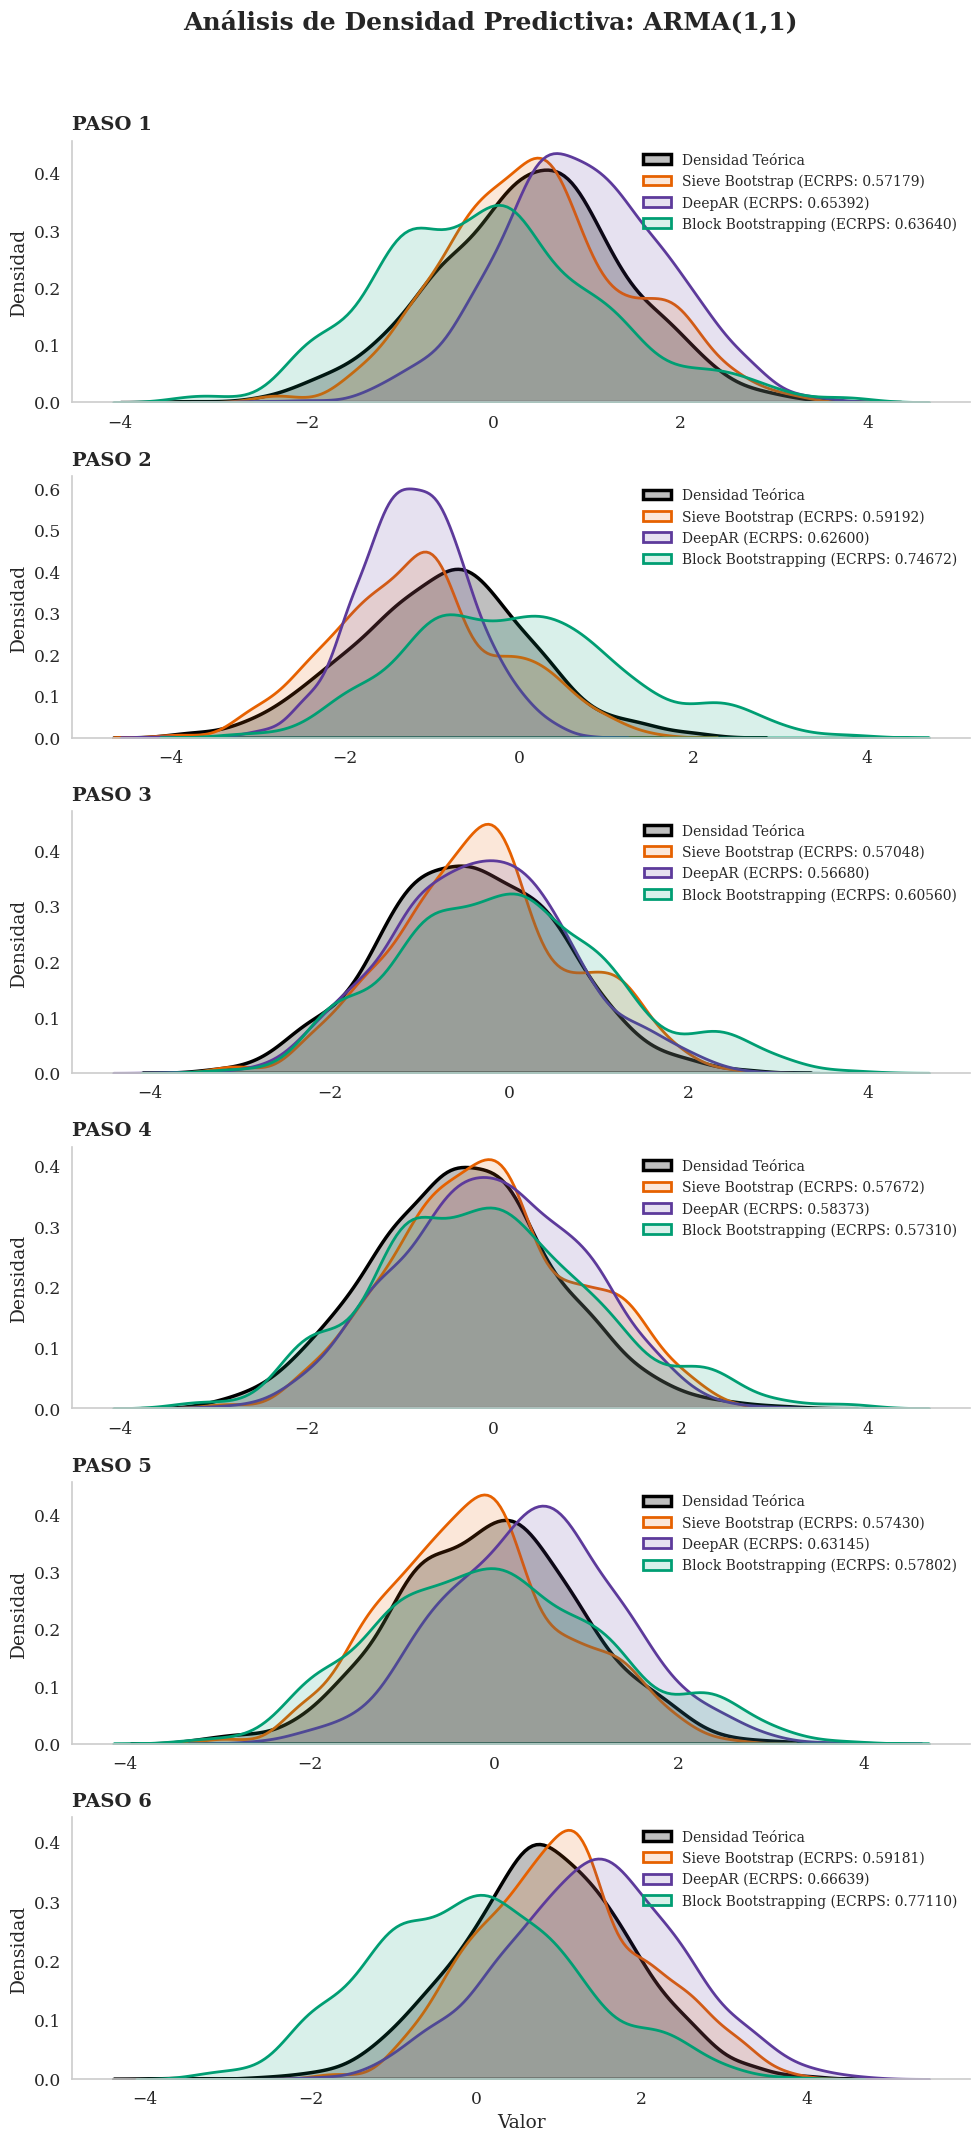

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from simulacion import ARMASimulation
from modelos import (CircularBlockBootstrapModel, SieveBootstrapModel, LSPM, LSPMW, 
                     DeepARModel, AREPD, MondrianCPSModel, AdaptiveVolatilityMondrianCPS,
                     EnCQR_LSTM_Model, TimeBalancedOptimizer)
from metricas import ecrps

class PipelineTop3PaperQuality:
    def __init__(self, n_boot: int = 1000, seed: int = 42):
        self.n_boot = n_boot
        self.seed = seed
        self.n_train = 200
        self.n_val = 40
        self.n_steps = 6
        
        # Paleta de colores científica (Colorblind-friendly / Paper Ready)
        self.academic_colors = {
            'Teórica': '#000000',      # Negro sólido para el Ground Truth
            'Top1': '#E66100',         # Naranja vibrante
            'Top2': '#5D3A9B',         # Púrpura profundo
            'Top3': '#009E73'          # Verde azulado (Teal)
        }

    def ejecutar(self):
        # 1. Simulación (Escenario ARMA)
        arma_cfg = {'nombre': 'ARMA(1,1)', 'phi': [0.75], 'theta': [-0.25]}
        simulator = ARMASimulation(
            phi=arma_cfg['phi'], theta=arma_cfg['theta'],
            noise_dist='normal', sigma=1.0, seed=self.seed
        )
        total_len = self.n_train + self.n_val + self.n_steps
        series, errors = simulator.simulate(n=total_len, burn_in=100)
        
        # 2. Modelos y Optimización
        models = {
            'Block Bootstrapping': CircularBlockBootstrapModel(n_boot=self.n_boot, random_state=self.seed),
            'Sieve Bootstrap': SieveBootstrapModel(n_boot=self.n_boot, random_state=self.seed),
            'LSPM': LSPM(random_state=self.seed),
            'LSPMW': LSPMW(rho=0.95, random_state=self.seed),
            'AREPD': AREPD(n_lags=5, rho=0.93, random_state=self.seed),
            'MCPS': MondrianCPSModel(n_lags=10, random_state=self.seed),
            'AV-MCPS': AdaptiveVolatilityMondrianCPS(n_lags=12, random_state=self.seed),
            'DeepAR': DeepARModel(hidden_size=20, n_lags=10, epochs=20, num_samples=self.n_boot, random_state=self.seed),
            'EnCQR-LSTM': EnCQR_LSTM_Model(n_lags=15, B=3, units=24, epochs=15, num_samples=self.n_boot, random_state=self.seed)
        }

        optimizer = TimeBalancedOptimizer(random_state=self.seed, verbose=False)
        best_params = optimizer.optimize_all_models(models, series[:self.n_train], series[self.n_train:self.n_train+self.n_val])
        
        # Congelar modelos con datos históricos
        for name, model in models.items():
            if name in best_params:
                for k, v in best_params[name].items():
                    if hasattr(model, k): setattr(model, k, v)
            if hasattr(model, 'freeze_hyperparameters'):
                model.freeze_hyperparameters(series[:self.n_train+self.n_val])

        # 3. Predicciones y Ranking
        plot_data = {t: {'true': None, 'preds': {}, 'scores': {}} for t in range(self.n_steps)}
        model_avg_ecrps = {name: [] for name in models.keys()}

        for t in range(self.n_steps):
            idx = self.n_train + self.n_val + t
            true_samples = simulator.get_true_next_step_samples(series[:idx], errors[:idx], n_samples=1000)
            plot_data[t]['true'] = true_samples

            for name, model in models.items():
                try:
                    p = model.fit_predict(series[:idx]) if "Bootstrap" in name else model.fit_predict(pd.DataFrame({'valor': series[:idx]}))
                    pred_array = np.asarray(p).flatten()
                    score = ecrps(pred_array, true_samples)
                    plot_data[t]['preds'][name] = pred_array
                    plot_data[t]['scores'][name] = score
                    model_avg_ecrps[name].append(score)
                except: continue

        top_3_names = sorted(model_avg_ecrps, key=lambda x: np.nanmean(model_avg_ecrps[x]))[:3]
        self._grafico_paper(plot_data, top_3_names, arma_cfg['nombre'])

    def _grafico_paper(self, plot_data, top_models, scenario_name):
        # Configuración de estilo Journal
        sns.set_context("paper", font_scale=1.4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['axes.linewidth'] = 1.2

        fig, axes = plt.subplots(self.n_steps, 1, figsize=(10, 3.5 * self.n_steps), sharex=False)
        fig.suptitle(f"Análisis de Densidad Predictiva: {scenario_name}", fontsize=18, fontweight='bold', y=1.02)

        for t in range(self.n_steps):
            ax = axes[t]
            step_num = t + 1
            
            # 1. Densidad Teórica (Ground Truth)
            true_dist = plot_data[t]['true']
            sns.kdeplot(true_dist, fill=True, color=self.academic_colors['Teórica'], 
                        alpha=0.25, linewidth=2.5, label='Densidad Teórica', ax=ax)

            # 2. Modelos Top 3
            colors_list = [self.academic_colors['Top1'], self.academic_colors['Top2'], self.academic_colors['Top3']]
            for i, name in enumerate(top_models):
                if name in plot_data[t]['preds']:
                    m_preds = plot_data[t]['preds'][name]
                    m_score = plot_data[t]['scores'][name]
                    
                    label_text = f"{name} (ECRPS: {m_score:.5f})"
                    sns.kdeplot(m_preds, fill=True, color=colors_list[i], 
                                alpha=0.15, linewidth=2, label=label_text, ax=ax)

            # Estética de Paper: Sin cuadrícula, solo ejes limpios
            ax.set_title(f"PASO {step_num}", loc='left', fontsize=14, fontweight='bold', pad=8)
            ax.set_ylabel("Densidad")
            ax.set_xlabel("Valor" if t == self.n_steps-1 else "")
            
            # Quitar cuadrícula y bordes innecesarios (Spines)
            ax.grid(False)
            sns.despine(ax=ax)
            
            # Leyenda elegante
            ax.legend(loc='upper right', frameon=False, fontsize=10)

        plt.tight_layout()
        plt.savefig("figura_tesis_ecrps.png", dpi=300, bbox_inches='tight')
        print("✅ Imagen de alta resolución guardada: figura_tesis_ecrps.png")
        plt.show()

if __name__ == "__main__":
    PipelineTop3PaperQuality().ejecutar()